<a href="https://colab.research.google.com/github/ananthu-raj/Image-Classification-Experimentation/blob/main/Chess_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Chess Image Classification**

In [10]:
# Importing libraries
#!pip install tensorflow-gpu
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers import Dense
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dropout
from tensorflow.keras import  layers, models
import tqdm
import numpy as np
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [103]:
from tensorflow.keras.layers import Conv2D,Dense,MaxPooling2D,Dropout,Flatten,Activation,MaxPool2D,BatchNormalization

In [95]:
# Checking the GPU Version
!nvidia-smi

Thu Nov 10 14:38:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    33W /  70W |  14632MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Basic EDA and Visualisations

['/content/drive/MyDrive/Chess/Rook', '/content/drive/MyDrive/Chess/Bishop', '/content/drive/MyDrive/Chess/Queen', '/content/drive/MyDrive/Chess/Pawn', '/content/drive/MyDrive/Chess/Knight']


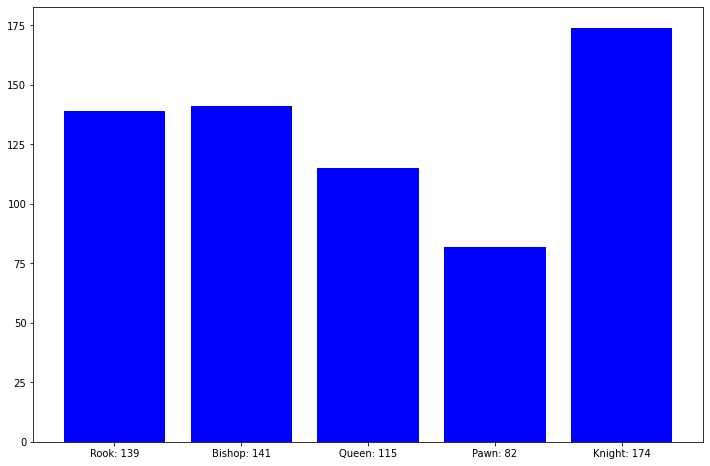

In [2]:
# To visualise the number of each chess pieces
dirname = '/content/drive/MyDrive/Chess'
dir_chess_folders = os.listdir(dirname)
dir_chess_paths = [os.path.join(dirname, path) for path in dir_chess_folders]
print(dir_chess_paths)

chess_dic = {}
for path in dir_chess_paths:
    head, tail = os.path.split(path)
    chess_dic[tail] = len(os.listdir(path))
label_list = ["{}: {}".format(key, chess_dic[key]) for key in chess_dic]
plt.figure(figsize=(12, 8))
plt.bar(range(len(chess_dic)), list(chess_dic.values()), color="blue")
plt.xticks(range(len(chess_dic)), list(label_list))
plt.show();

In [13]:
# Checking Resolutions of Every Image
# Reference : https://stackoverflow.com/questions/1507084/how-to-check-dimensions-of-all-images-in-a-directory-using-python
from PIL import Image 

folder_images = dirname
size_images = dict()

for dirpath, _, filenames in os.walk(folder_images):
    for path_image in filenames:
        image = os.path.abspath(os.path.join(dirpath, path_image))
        with Image.open(image) as img:
            width, heigth = img.size
            size_images[path_image] = {'width': width, 'heigth': heigth}
resolutions = pd.DataFrame.from_dict(size_images, orient ='index')
resolutions

,width,heigth
00000216_resized.jpg,224,224
00000052_resized.jpg,224,224
00000053_resized.jpg,224,224
00000168_resized.jpg,224,224
00000104_resized.jpg,224,224
...,...,...
00000326_resized.jpg,224,224
00000310_resized.jpg,224,224
00000162_resized.jpg,224,224
00000322_resized.jpg,224,224


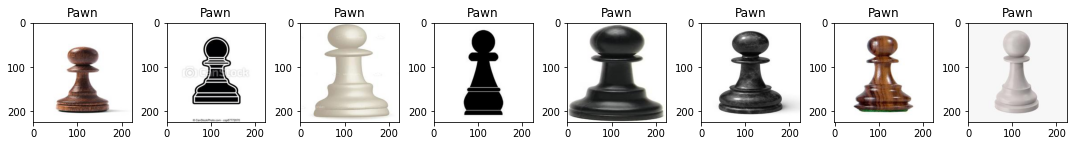

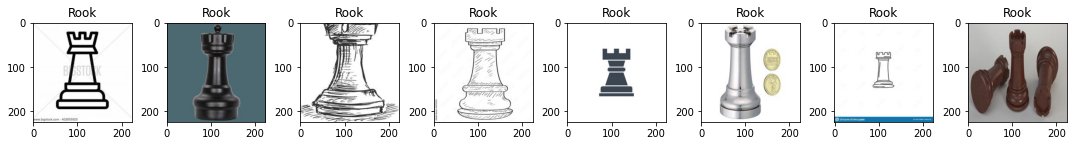

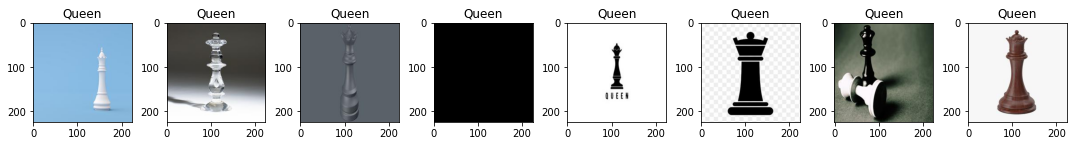

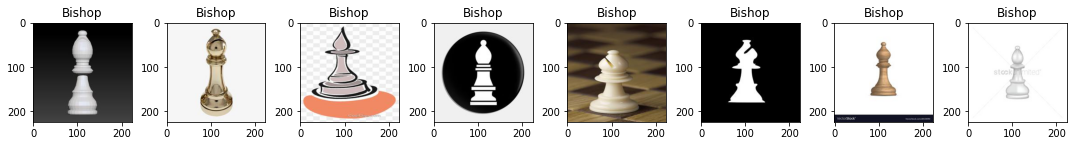

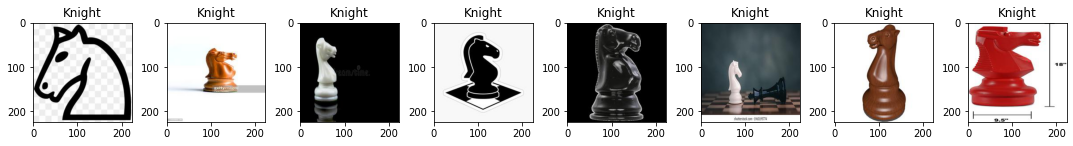

In [105]:
def plot_imgs(item_dir, title=" ", num_imgs=4, cmap='viridis'):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:num_imgs]

    plt.figure(figsize=(15, 15))
    for idx, img_path in enumerate(item_files):
        plt.subplot(8, 8, idx+1)
        img = plt.imread(img_path, 0)
        plt.title(title)
        plt.imshow(img, cmap=cmap)

    plt.tight_layout()
for path in dir_chess_paths:
    head, tail = os.path.split(path)
    plot_imgs(path, tail, 8)

# CNN

In [106]:
img_size_h = 300
img_size_w = 300

train_datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.3)
input_shape = (img_size_h, img_size_w, 3)
batch_size = 16
train_generator = train_datagen.flow_from_directory(
    dirname,
    target_size=(img_size_h, img_size_w),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,  # we shuffle our images for better performance
    seed=8)
validation_generator = train_datagen.flow_from_directory(
    dirname,
    target_size=(img_size_h, img_size_w),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=7)

Found 458 images belonging to 5 classes.
Found 193 images belonging to 5 classes.


In [107]:
model = Sequential([

    Conv2D(16, (3, 3), input_shape=input_shape, padding='same', activation='relu'),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPool2D((2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), padding='same', activation='relu'),
    # Conv2D(128, (3, 3), padding='same', activation='relu'),
    MaxPool2D((2, 2)),
    Dropout(0.2),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(5, activation='softmax')

])

In [108]:
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 300, 300, 16)      448       
                                                                 
 conv2d_33 (Conv2D)          (None, 300, 300, 32)      4640      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 150, 150, 32)     0         
 g2D)                                                            
                                                                 
 dropout_16 (Dropout)        (None, 150, 150, 32)      0         
                                                                 
 conv2d_34 (Conv2D)          (None, 150, 150, 64)      18496     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 75, 75, 64)       0         
 g2D)                                                 

In [110]:
history = model.fit_generator(train_generator, epochs=25, validation_data=validation_generator)

Epoch 1/25


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


29/29 [==============================] - 3s 102ms/step - loss: 1.0304 - accuracy: 0.6550 - val_loss: 1.5872 - val_accuracy: 0.3057
Epoch 2/25
29/29 [==============================] - 3s 103ms/step - loss: 1.2175 - accuracy: 0.5415 - val_loss: 1.5164 - val_accuracy: 0.3679
Epoch 3/25
29/29 [==============================] - 3s 99ms/step - loss: 0.7230 - accuracy: 0.7598 - val_loss: 1.4198 - val_accuracy: 0.4404
Epoch 4/25
29/29 [==============================] - 3s 100ms/step - loss: 0.4512 - accuracy: 0.8581 - val_loss: 1.7911 - val_accuracy: 0.4352
Epoch 5/25
29/29 [==============================] - 3s 101ms/step - loss: 0.4395 - accuracy: 0.8712 - val_loss: 1.7723 - val_accuracy: 0.4560
Epoch 6/25
29/29 [==============================] - 3s 101ms/step - loss: 0.2330 - accuracy: 0.9301 - val_loss: 2.1168 - val_accuracy: 0.4819
Epoch 7/25
29/29 [==============================] - 3s 100ms/step - loss: 0.2329 - accuracy: 0.9345 - val_loss: 2.1266 - val_accuracy: 0.4352
Epoch 8/25
29/29 [

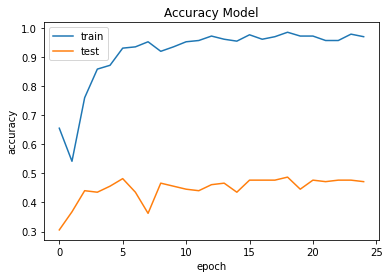

In [119]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

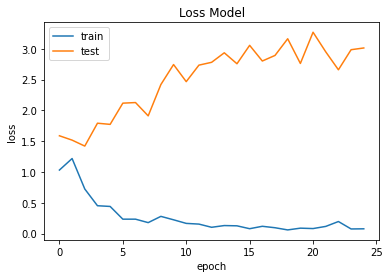

In [120]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()